In [1]:
import numpy as np
import matplotlib.pyplot as pl
import matplotlib.cm as cm
import random

import itertools
import pickle
import importlib as imp
import copy
import dynamics_funcs as dyf
import common_funcs as comf
import learning_simple_seq as lrn
from sklearn.decomposition import PCA
import tmp as nn
import os
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import argrelmin, argrelmax
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d

In [2]:
def model_initialization_rcl(inet,NN,BETA,gamma,_flg,_Npat=5,_Nin=1):
    if _flg=="simple":
        if _Nin==1:
            #fname="mod_results_simple_inet%d_Npat%g_%g" % (inet,_Npat,BETA)
            fname="used_data/results_simple_pert_inet%d_Npat%g_%g" % (inet,_Npat,BETA)
        else:
            fname="mod_results_simple_inet%d_Npat%d_Nin%d_%g" % (inet,_Npat,_Nin,BETA)
    else:
        fname="./used_data/results_DMS_inet%d_%g_%g" % (inet,BETA,gamma)
    with open(fname, 'rb') as f:
        _NN = pickle.load(f)

    for i in vars(_NN).keys():
        vars(NN)[i]=vars(_NN)[i]
        
    return NN

def calc_rsuc_RT(_list_all,_r_pert):
    thrs_RT=0.8
    NNtmp=_list_all["NNnew"]

    # no perturbation
    dyn_sep,t_sep,tid_sep=get_sepdata(_list_all,thrs_sep=1.1)
    RTs_norm=get_RT(NNtmp,dyn_sep,t_sep,tid_sep,thrs_RT,is_bin=False,is_noise=False) 

    r_suc_tmp=[_r_pert]
    mRT_tmp=[_r_pert]
    sdRT_tmp=[_r_pert]
    for i in range(NNtmp.Npat_intrial):
        RTtmp=np.array(RTs_norm["correct"][i])
        r_suc_tmp.append(len(RTtmp)/NNtmp.Nround)
        if len(RTtmp)==0:
            mRT_tmp.append(np.nan)
            sdRT_tmp.append(np.nan)
        else:
            mRT_tmp.append(np.mean(RTtmp[:,0]))
            sdRT_tmp.append(np.std(RTtmp[:,0]))


    return r_suc_tmp,mRT_tmp,sdRT_tmp

def gen_fig(NN,list_dyn_all,list_t_all,is_bin,t1=95,t2=110): 

    cset=["b","gray","r","cyan","green","pink","yellow"]
    lw=[1,5,2,1,1,1,1]
    alpha=[1,0.5,1,1,1,1,1]
    tmptrgt=np.hstack((NN.ipt_trgt[1][0][2][:NN.Ntrgt,:],NN.ipt_trgt[1][1][2][:NN.Ntrgt,:]))
    
    pl.figure()
    
    for itrial in range(NN.Npat_intrial):
        pl.subplot(2,2,itrial+1)
        
        if itrial in [0,3]:
            dynid=0
        else:
            dynid=1
        
        for iround in range(NN.Nround):
            
            for v,[dyn_all,t_all] in enumerate(zip(list_dyn_all,list_t_all)):
                tmp=np.copy(dyn_all[iround][itrial][:,:NN.Ntrgt])
                if is_bin:
                    tmp[tmp>0]=1
                    tmp[tmp<0]=-1
                tmpdyn=tmp@tmptrgt[:,:]/NN.Ntrgt
                tmpt=t_all[iround][itrial]
                pl.plot(tmpt-tmpt[0],tmpdyn[:,dynid],c=cset[v],lw=lw[v],alpha=alpha[v])
                
        pl.xlim(t1,t2)
        
    return

def get_RT(NN,dyn_all,t_all,tid_all,thrs_RT,is_bin,is_noise): 
    t_offset=2  # check reaction time for t>t_offset + t_delay_end
    Dt=0.25  # sampling interval
    
    RTc,RTic,RTo=[],[],[]
    tmptrgt=np.hstack((NN.ipt_trgt[1][0][2][:NN.Ntrgt,:],NN.ipt_trgt[1][1][2][:NN.Ntrgt,:]))
    
    for itrial in range(NN.Npat_intrial):
        RTc.append([]);RTic.append([]);RTo.append([])
        if itrial in [0,3]:
            icorrect=0
        else:
            icorrect=1
        
        for iround in range(NN.Nround):
            tmp=np.copy(dyn_all[iround][itrial][:,:NN.Ntrgt])
            if is_bin:
                tmp[tmp>0]=1
                tmp[tmp<0]=-1
            tmpdyn=tmp@tmptrgt[:,:]/NN.Ntrgt
            if is_noise:
                tmpdyn+=np.random.normal(0,0.05,tmpdyn.shape)
            tmpt=t_all[iround][itrial]

            tmpid=tid_all[iround][itrial][2]-tid_all[iround][itrial][0] +int(t_offset/Dt)
            tmptmp=[ [k+tmpid,int(np.where(v>thrs_RT)[0])] for k,v in enumerate(tmpdyn[tmpid:,:]) if np.any(v>thrs_RT)]

            if len(tmptmp)>0:
                thrs_id=tmptmp[0][0]
                if tmptmp[0][1]==icorrect:
                    RTc[-1].append([tmpt[thrs_id]-tmpt[0],iround])
                else:
                    RTic[-1].append([tmpt[thrs_id]-tmpt[0],iround])
            else:
                thrs_id=len(tmpt)-1
                RTo[-1].append([tmpt[thrs_id]-tmpt[0],iround])
                
    return {"correct":RTc,"incorrect":RTic,"nodecision":RTo}

def calc_stab_DMS(_list_all,id_normal,_list_para):
    _stab=[]
    
    ###### prepare yp (initial slow state at onset of test input) and xp (the fast pattern after convergence,  instead of the target pattern)
    dicttmp=_list_all[id_normal]
    dyn,dyn1,tid=dicttmp["dyn"],dicttmp["dyn1"],dicttmp["t_tic"]
    NN=dicttmp["NNnew"]
    
    yp_all,xp_all=[],[]
    for iset in range(NN.Npat_intrial):
        i_event=np.where(dyn1[:,0,0]==tid[iset*3+2])[0][-1]
        yp=dyn1[i_event,1:]
        xp=dyn[i_event+200,1:]  
        yp_all.append(np.copy(yp))
        xp_all.append(np.copy(xp))
    #################

    for ip,p in enumerate(_list_para):
        _stab.append([])
        dicttmp=_list_all[ip]
        NN=dicttmp["NNnew"]
        
        for iset in range(NN.Npat_intrial):
            ipt=NN.ipt_trgt[0][iset][2]
            yp,xp=yp_all[iset],xp_all[iset]
            tmp=xp.T @ np.tanh( NN.BETA*(NN.J@xp+NN.gamma_y*(NN.Jxy@yp)  + NN.gamma*ipt))/NN.N
            _stab[-1].append(tmp[0,0])
    return np.array(_stab)

def separate_dyn(NN,prj_dyn,dyn,tid,t,t_offset=2,thrs=0.9):
    Dt=0.25
    it_offset=int(t_offset/Dt)
    
    dyn_all=[]
    t_all=[]
    tid_all=[]

    for iround in range(NN.Nround):
        dyn_all.append([]); t_all.append([]);tid_all.append([])

        t_end=[]
        for i in range(NN.Npat_intrial):
            t_end.append([])

            # detect time at which the overlap 1 reaches thrs
            t_dec=[k for k,v in enumerate(prj_dyn[tid[12*iround+3*i+2]+it_offset:tid[12*iround+3*i+3],0]) if v>thrs]
            if len(t_dec)!=0:
                t_end[-1].append(tid[12*iround+3*i+2]+t_dec[0]+it_offset)
            else:
                t_end[-1].append(tid[12*iround+3*i+3])

            # detect time at which the overlap 2 reaches thrs
            t_dec=[k for k,v in enumerate(prj_dyn[tid[12*iround+3*i+2]+it_offset:tid[12*iround+3*i+3],1]) if v>thrs]
            if len(t_dec)!=0:
                t_end[-1].append(tid[12*iround+3*i+2]+t_dec[0]+it_offset)
            else:
                t_end[-1].append(tid[12*iround+3*i+3])

            ttmp=np.min(t_end[-1])
            dyn_all[-1].append(dyn[tid[12*iround+3*i]+1:ttmp+1])
            t_all[-1].append(t[tid[12*iround+3*i]+1:ttmp+1])
            tid_all[-1].append(tid[12*iround+3*i:12*iround+3*(i+1)])
            
    return dyn_all,t_all,tid_all

def get_sepdata(dict_data,thrs_sep):
    NN=dict_data["NNnew"]
    dyn=dict_data["dyn"][:,1:,0]
    t=dict_data["dyn"][:,0,0]
    t_tic=dict_data["t_tic"]

    tmptrgt=np.hstack((NN.ipt_trgt[1][0][2][:NN.Ntrgt,:],NN.ipt_trgt[1][1][2][:NN.Ntrgt,:]))
    tid=[np.where(t==k)[0][0] for k in t_tic]

    prj_dyn=dyn[:,:NN.Ntrgt]@tmptrgt/NN.Ntrgt
    return separate_dyn(NN,prj_dyn,dyn,tid,t,thrs=thrs_sep)

def get_peak_y(dyn,_NN):
    prj=dyn[:,1:,0]@_NN.ipt_trgt[1]
    t=dyn[:,0,0]
    init_t=np.where(t>1000)[0][0]
    ids_t=np.argmax(prj[init_t:],axis=0)+init_t
    return ids_t,np.array([dyn[id_t,1:,0] for id_t in ids_t]).T

def Hev(x):
    xtmp=np.copy(x)
    xtmp[x>0]=1
    xtmp[x<=0]=-1
    return xtmp

def get_trans(dyn_p):
    t_trans=[]
    ttmp,ttmp1=NN.check_iterations(dyn_p,nitr=5,thrs=70)
    if ttmp==False:
        tmp=np.ones(NN.Npat)
        tmp[:]=np.nan
        t_trans=tmp
    else:
        for i in range(NN.Npat):
            ttmp=NN.detect_t_trans_1(dyn_p, i,thrs=70)
            ntmp=len(np.arange(len(ttmp[1]))[ttmp[1]<ttmp[0][0]])
            del ttmp[1][:ntmp]
            ntmp=min(len(ttmp[0]),len(ttmp[1]))
            ttmp[0],ttmp[1]=ttmp[0][:ntmp],ttmp[1][:ntmp]
            t_trans.append(ttmp)
    return t_trans

def get_peri_stay_trns(t_trans_all,para_list,net_list):
    T_peri_all,T_stay_all,T_trns_all=[],[],[]
    for inet in range(Nnet):
        T_stay_all.append([])
        T_trns_all.append([])
        T_peri_all.append([])

        if not inet in net_list:
            for ib in range(len(para_list)):
                tmp=np.zeros(NN.Npat)
                tmp[:]=np.nan
                T_stay_all[-1].append(tmp)
                T_trns_all[-1].append(tmp)
                T_peri_all[-1].append(tmp)

            continue

        for ib in range(len(para_list)):
            t_trans=t_trans_all[inet][ib]
            if type(t_trans[0])==np.float64:  # check nan
                tmp=np.zeros(NN.Npat)
                tmp[:]=np.nan
                T_stay_all[-1].append(tmp)
                T_trns_all[-1].append(tmp)
                T_peri_all[-1].append(tmp)
            else:
                T_peri,T_stay,T_trns=[],[],[]
                for i in range(NN.Npat):
                    ttmp0,ttmp1=copy.deepcopy(t_trans[i][1]),copy.deepcopy(t_trans[(i+1)%NN.Npat][0])
                    ntmp=len(np.arange(len(ttmp1))[ttmp1<ttmp0])
                    del ttmp1[:ntmp]
                    ntmp=min(len(ttmp0),len(ttmp1))
                    ttmp0,ttmp1=np.array(ttmp0[:ntmp]),np.array(ttmp1[:ntmp])
                    T_trns.append( np.mean((ttmp1-ttmp0)[-4:-1]) )
                    T_stay.append( np.mean((np.array(t_trans[i][1])-np.array(t_trans[i][0]))[-4:-1]) )
                    T_peri.append( np.mean((np.array(t_trans[i][0][1:])-np.array(t_trans[i][0][:-1]))[-4:-1]) )
                T_stay_all[-1].append(T_stay)
                T_trns_all[-1].append(T_trns)
                T_peri_all[-1].append(T_peri)

    return np.array(T_peri_all),np.array(T_stay_all),np.array(T_trns_all)

def comput_stab(inet,_list_para,_type_para):
    stab=[]
    
    ###  get the value of the slow population used for stability.
    NN=model_initialization_rcl(inet,nn.myNN("simple",inet),3,1,"simple",_Npat=5,_Nin=1)
    NN.Nround=1
    NN.Tdyn=4000
    x0=NN.x_final
    y0=NN.y_final

    x,y,dyn_p,dyn1_p=NN.calc_dyn([x0,y0],True,False)
    ids_t,tmp=get_peak_y(dyn1_p,NN)
    tmpid=np.append(NN.Npat-1,np.arange(NN.Npat)[:-1])  #  y at the peak of pat n is used for stability of pat n+1
    yp=tmp[:,tmpid]
    
    
    for ig,para in enumerate(_list_para):
        if _type_para=="beta":
            NN.BETA=para
        elif _type_para=="topdown":
            NN.ipt_trgt[0]=para
        elif _type_para=="contI":
            NN.gamma=para
        else:
            print("error")
            
        tmp=NN.ipt_trgt[1].T @ np.tanh( NN.BETA*(NN.J@NN.ipt_trgt[1]+NN.gamma_y*np.tanh( NN.Jxy@yp)  + NN.gamma*np.tile(NN.ipt_trgt[0],(1,NN.Npat))))/NN.N 
        stab.append(np.diag(tmp))

    return np.array(stab)

# choose success networks.
def get_success_net_DMS():
    list_inet=[]
    BETA=1.5
    for inet in range(10):
        fname="./used_data/results_DMS_inet%d_%g_%g" % (inet,BETA,1.2)
        with open(fname, 'rb') as f:
            _NN = pickle.load(f)

        if np.mean(_NN.score_all[-1]) > 0.8:
            print(inet,np.mean(_NN.score_all[-1]))
            list_inet.append(inet)
            
    return list_inet

def gen_conv_finalstate(dyn_dict,iset):
    NNtmp=dyn_dict["NNnew"]
    dyn_tmp,t_tmp,_=get_sepdata(dyn_dict,thrs_sep=0.95)
    min_t=min([len(i[iset])   for i in dyn_tmp])
    tmpdyn=np.array([i[iset][:min_t]   for i in dyn_tmp])
    tmpdyn=tmpdyn[:,1000:,:NNtmp.Ntrgt]@NNtmp.ipt_trgt[1][iset][2][:NNtmp.Ntrgt]/NNtmp.Ntrgt

    dyn_m=np.mean(tmpdyn[:,:,0],axis=0)
    dyn_std=np.std(tmpdyn[:,:,0],axis=0)

    pl.plot(t_tmp[0][iset][1000:min_t],dyn_m)
    pl.fill_between(t_tmp[0][iset][1000:min_t], dyn_m-dyn_std, dyn_m+dyn_std, alpha=0.3, label='±1 Std Dev')


# schematic image

In [ ]:
# schimatic image for  beta gradation
x=np.linspace(-1,1,100)
for ib,b in enumerate(np.exp(np.linspace(-0.5,2,5))):
    pl.plot(x,np.tanh(b*x),c=cm.gray(1-ib/5.0))
pl.savefig("gradation_sigmoid.eps")

In [ ]:
S=np.zeros((11,11))
S[:,0]=1;S[0,:]=1;S[:,-1]=1;S[-1,:]=1
X=np.zeros(S.shape)
for i in range(len(X)-2):
    X[i+1,i+1]=1;X[-(i+2),i+1]=1
        
list_ratio=[[1,0],[0,1],[0.8,0.2],[0.2,0.8],[0.6,0.4],[0.4,0.6]]
pl.figure(figsize=(4,7))


for ifig in range(6):
    pl.subplot(3,2,1+ifig)
    pl.pcolor(list_ratio[ifig][0]*S+list_ratio[ifig][1]*X,cmap="Greys")
    pl.clim(0,1)
    pl.tick_params(bottom=False, left=False, right=False, top=False)
    pl.xticks(color="None");pl.yticks(color="None")
    
pl.savefig("schm_DMS.eps")

# DMS

## learning

In [ ]:
### learning DMS
BETA=1.5
imp.reload(nn)
for inet in range(5,10):
    NN=nn.myNN("DMS",inet,Nround=1000)
    NN.flg1="perturb_2ndstim" 
    NN.gamma  =1.2
    NN.gamma_y=1.0
    NN.BETA=BETA
    NN.THRS_STOP=0.8
    
    NN.Tdyn=30
    NN.Tdyn_del=30
    NN.Tdyn_test=30
    
    NN.calc_dyn([_,_],False,True)
   
"""
BETA=2
imp.reload(nn)
for inet in range(10):
    NN=nn.myNN("DMS",inet,Nround=1000)
    NN.flg1="perturb_2ndstim" 
    NN.gamma  =1.2
    NN.gamma_y=0.8
    NN.BETA=BETA
    NN.THRS_STOP=0.85
    
    NN.Tdyn=30
    NN.Tdyn_del=30
    NN.Tdyn_test=30
    
    NN.calc_dyn([_,_],False,True)
"""

## check recall dynamics in normal condition  (Fig 4)

In [ ]:
### plot learning curves
curves_all=[]
for inet in range(10):
    fname="./used_data/results_DMS_inet%d_%g_%g" % (inet,BETA,1.2)
    with open(fname, 'rb') as f:
        _NN = pickle.load(f)
        
    curves_all.append([])
    for i in _NN.score_all:
        curves_all[-1].append(np.mean(i))

    pl.plot(curves_all[-1])
#pl.savefig("lrn_curves.eps")

In [38]:
### generation of sample trials  in the normal condition
BETA=1.5

imp.reload(nn)
list_inet=get_success_net_DMS()
purturb_inpt="_"

list_all_norm=[]
for inet in list_inet[2:3]:
    NNnew=model_initialization_rcl(inet,nn.myNN("DMS",inet),BETA=BETA,gamma=1.2,_flg="DMS")  # copy instance parameters used in learning 

    NNnew.BETArcl1=NNnew.BETA
    NNnew.BETArcl2=NNnew.BETA
    NNnew.Nround=100
    NNnew.flg1=purturb_inpt
    _,_,dyn,dyn1,t_tic=NNnew.calc_dyn([_,_],True,False)

    list_all_norm.append({"dyn":copy.deepcopy(dyn),"dyn1":copy.deepcopy(dyn1),"t_tic":copy.deepcopy(t_tic),"NNnew":copy.deepcopy(NNnew)})

0 0.8125
1 0.8625
3 0.8375
5 0.9
7 0.8375
8 0.8125
9 0.8125


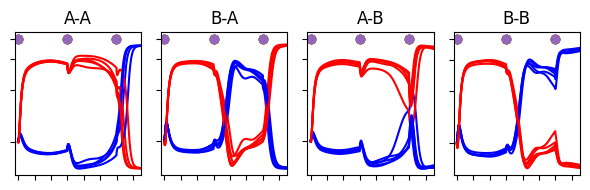

In [40]:
### plot and check if the network succeeds  (outputdynamics)
idnet=0 #inet=3

dict_data=list_all_norm[idnet]
NNtmp=dict_data["NNnew"]
dyn_sep,t_sep,tid_sep=get_sepdata(dict_data,thrs_sep=0.95)
tmptrgt=np.hstack((NNtmp.ipt_trgt[1][0][2][:NNtmp.Ntrgt,:],NNtmp.ipt_trgt[1][1][2][:NNtmp.Ntrgt,:]))

list_title=["A-A","B-A","A-B","B-B"]
pl.figure(figsize=(6,2))
for itrial in range(4):
    pl.subplot(1,4,itrial+1)
    for iround in range(5):
        if iround==0:
            pl.title(list_title[itrial])
        tmpdyn=dyn_sep[iround][itrial][1:,:NNtmp.Ntrgt]@tmptrgt[:,:]/NNtmp.Ntrgt
        tmpt=t_sep[iround][itrial][1:]
        tmptid=tid_sep[iround][itrial]
        pl.plot(tmpt-tmpt[0],tmpdyn[:,0],c="b")
        pl.plot(tmpt-tmpt[0],tmpdyn[:,1],c="r")
        pl.scatter(tmpt[tmptid-tmptid[0]]-tmpt[0],np.ones(3))
        pl.xticks(np.linspace(0,70,8))
        pl.yticks([0,0.5,0.8,1])
        pl.xlim(-2,75)
        pl.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
pl.tight_layout()
#pl.savefig("DMS_sample_dyn.eps")

## difficulty (Fig6, 7)

In [ ]:
### generation of sample trials  in the diff beta including the original beta
imp.reload(nn)
list_inet=get_success_net_DMS()

BETA=1.5  # for the paper 2024.10.13
is_save=True   # data is save in a file for each network  due to large datasize  (for modulation of beta, data is save in a file for all networks)


list_pval=[0,0.01,0.02,0.03,0.04,0.05]
purturb_inpt="_"  # purturbation on the input is or not.
n_trials=10
Nsamp=20
 

for idnet, inet in enumerate(list_inet[:-1]):
    print(idnet)
    if is_save:
        list_all_pert=[]

    for k in range(Nsamp):  ### caution!!!  Nsamp loop -> list_pval, otherwise perturbations are accumulated.
        list_all_pert.append([])
        for p in list_pval:
            NNnew=model_initialization_rcl(inet,nn.myNN("DMS",inet),BETA=BETA,gamma=1.2,_flg="DMS")
            NNnew.flg1=purturb_inpt  # dummy   # random pertub input (only lrn proc) is not used
            NNnew.Nround=n_trials

            NNnew.BETArcl1, NNnew.BETArcl2=NNnew.BETA,NNnew.BETA        
            tmptrgt=np.hstack((NNnew.ipt_trgt[1][0][2][:NNnew.Ntrgt,:],NNnew.ipt_trgt[1][1][2][:NNnew.Ntrgt,:]))
            # ipt_trgt[1][0][2]: match pattern ipt_trgt[1][1][2]: non-match
            
            ######  perturbed inputs   ###########
            ipt,ipt1=NNnew.ipt_trgt[0][0][0],NNnew.ipt_trgt[0][1][0]
            d=int(p*NNnew.N)
            diff_id=np.arange(NNnew.N)[np.abs(ipt[:,0]-ipt1[:,0])>1]
            pert_id=np.array(random.sample(list(diff_id),d))

            for i in range(NNnew.Npat_intrial):
                if len(pert_id)!=0:
                    NNnew.ipt_trgt[0][i][2][pert_id,0]*=-1
            ################################
                    
            _,_,dyn,dyn1,t_tic=NNnew.calc_dyn([_,_],True,False)

    
            if is_save:
                list_all_pert[-1].append({"dyn":copy.deepcopy(dyn),"dyn1":copy.deepcopy(dyn1),"t_tic":copy.deepcopy(t_tic),"NNnew":copy.deepcopy(NNnew),"pert_id":copy.deepcopy(pert_id)})

    f=open("./used_data/DMS_pert_dyn_more1_inet%d"%inet,"wb")  #  case:    NNnew.BETArcl1, NNnew.BETArcl2=beta,beta 
    pickle.dump([list_all_pert,list_pval],f)
    f.close()


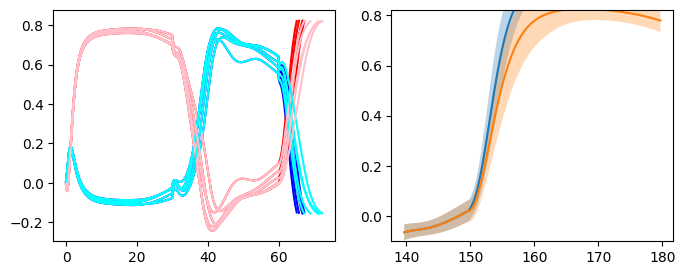

In [41]:
# plot comparing dyn
inet=3
ismp,iset,ip=1,1,2
#ismp,iset,ip=3,3,2

f = open("./used_data/DMS_pert_dyn_inet%d"%inet,"rb")
tmp=pickle.load(f)
list_all_pert,list_pval=tmp[0],tmp[1]
f.close()



pl.figure(figsize=(8,3))
pl.subplot(1,2,1)

####  original dynamics   #### 
dyn_dict=list_all_pert[ismp][0]
NNtmp=dyn_dict["NNnew"]
dyn_tmp,t_tmp,_=get_sepdata(dyn_dict,thrs_sep=0.82)
tmptrgt=np.hstack((NNtmp.ipt_trgt[1][0][2][:NNtmp.Ntrgt,:],NNtmp.ipt_trgt[1][1][2][:NNtmp.Ntrgt,:]))

for i in range(5):
    tmpdyn=dyn_tmp[i][iset][1:,:NNtmp.Ntrgt]@tmptrgt/NNtmp.Ntrgt
    tmpt=t_tmp[i][iset][1:]-t_tmp[i][iset][1]
    pl.plot(tmpt,tmpdyn[:,0],c="b")
    pl.plot(tmpt,tmpdyn[:,1],c="r")
    
    
####  dynamics with perturbation  #####
dyn_dict=list_all_pert[ismp][ip]
NNtmp=dyn_dict["NNnew"]
dyn_tmp,t_tmp,_=get_sepdata(dyn_dict,thrs_sep=0.82)
tmptrgt=np.hstack((NNtmp.ipt_trgt[1][0][2][:NNtmp.Ntrgt,:],NNtmp.ipt_trgt[1][1][2][:NNtmp.Ntrgt,:]))

for i in range(5):
    tmpdyn=dyn_tmp[i][iset][1:,:NNtmp.Ntrgt]@tmptrgt/NNtmp.Ntrgt
    tmpt=t_tmp[i][iset][1:]-t_tmp[i][iset][1]
    pl.plot(tmpt,tmpdyn[:,0],c="cyan")
    pl.plot(tmpt,tmpdyn[:,1],c="pink")
    
    
######  expansion  ########
pl.subplot(1,2,2)
gen_conv_finalstate(list_all_pert[ismp][0],iset)
gen_conv_finalstate(list_all_pert[ismp][ip],iset)
pl.ylim(-0.1,0.82)

del list_all_pert,list_pval,tmp
#pl.savefig("DMS_diff_sample_dyn.eps")

In [42]:
### stability  and ratio_suc (rsuc), reaction time (mRT)

Nsamp=5
list_inet=get_success_net_DMS()

stab_all,rsuc_all,mRT_all,sdRT_all=[],[],[],[]
for inet in list_inet[:-1]:
    stab,rsuc,mRT,sdRT=[],[],[],[]
    
    f = open("./used_data/DMS_pert_dyn_inet%d"%inet,"rb")
    tmp=pickle.load(f)
    list_all_pert,list_pval=tmp[0],tmp[1]
    f.close()
    for ismp in range(5):
        stab.append(calc_stab_DMS(list_all_pert[ismp],0,list_pval))
        rsuc.append([]);mRT.append([]),sdRT.append([])
        for ip,p in enumerate(list_pval):
            tmp=list_all_pert[ismp][ip]
            rtmp,rttmp,sdrttmp=calc_rsuc_RT(tmp,p)
            rsuc[-1].append(rtmp); mRT[-1].append(rttmp); sdRT[-1].append(sdrttmp)
    del list_all_pert,list_pval,tmp
    print("e")
    
    f = open("./used_data/DMS_pert_dyn_more_inet%d"%inet,"rb")
    tmp=pickle.load(f)
    list_all_pert,list_pval=tmp[0],tmp[1]
    f.close()
    
    for ismp in range(5):
        stab.append(calc_stab_DMS(list_all_pert[ismp],0,list_pval))
        rsuc.append([]);mRT.append([]),sdRT.append([])
        for ip,p in enumerate(list_pval):
            tmp=list_all_pert[ismp][ip]
            rtmp,rttmp,sdrttmp=calc_rsuc_RT(tmp,p)
            rsuc[-1].append(rtmp); mRT[-1].append(rttmp); sdRT[-1].append(sdrttmp)
    del list_all_pert,list_pval,tmp
    print("e")
    
    f = open("./used_data/DMS_pert_dyn_more1_inet%d"%inet,"rb")
    tmp=pickle.load(f)
    list_all_pert,list_pval=tmp[0],tmp[1]
    f.close()

    for ismp in range(20):
        stab.append(calc_stab_DMS(list_all_pert[ismp],0,list_pval))
        rsuc.append([]);mRT.append([]),sdRT.append([])
        for ip,p in enumerate(list_pval):
            tmp=list_all_pert[ismp][ip]
            rtmp,rttmp,sdrttmp=calc_rsuc_RT(tmp,p)
            rsuc[-1].append(rtmp); mRT[-1].append(rttmp); sdRT[-1].append(sdrttmp)
    del list_all_pert,list_pval,tmp
    print("e")
    
    stab_all.append(stab);rsuc_all.append(rsuc);mRT_all.append(mRT);sdRT_all.append(sdRT)
stab_all=np.array(stab_all);rsuc_all=np.array(rsuc_all);mRT_all=np.array(mRT_all);sdRT_all=np.array(sdRT_all)

0 0.8125
1 0.8625
3 0.8375
5 0.9
7 0.8375
8 0.8125
9 0.8125
e
e
e
e
e
e
e
e
e
e
e
e
e
e
e
e
e
e


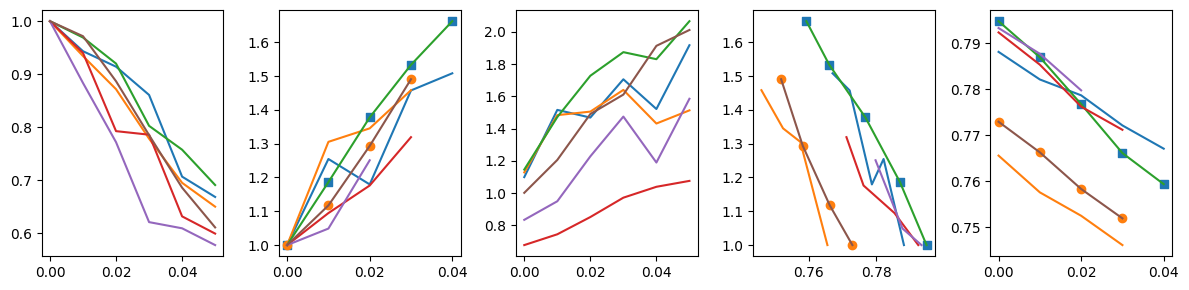

In [43]:
# plot success ratio, increase in RT,  stability vs RT

list_pval=[0,0.01,0.02,0.03,0.04,0.05]
t_onset=60
mset=[" "," ","s","","","o"]
fig=pl.figure(figsize=(12,3))
axes=[fig.add_subplot(151),fig.add_subplot(152),fig.add_subplot(153),fig.add_subplot(154),fig.add_subplot(155)]

for idnet in range(6):
    stab,mRT,sdRT,rsuc=stab_all[idnet],mRT_all[idnet],sdRT_all[idnet],rsuc_all[idnet]
    stab_mean,mRT_mean,sdRT_mean,rsuc_mean=[],[],[],[]
    for ismp in range(30):
        stab_mean.append(np.mean(stab[ismp],axis=1))
        mRT_mean.append(np.mean(mRT[ismp][:,1:]-t_onset,axis=1))
        sdRT_mean.append(np.mean(sdRT[ismp][:,1:],axis=1))
        rsuc_mean.append(np.mean(rsuc[ismp][:,1:],axis=1))
        
    stab_mean,mRT_mean,rsuc_mean=np.array(stab_mean),np.array(mRT_mean),np.array(rsuc_mean)
    
    rsuctmp=np.nanmean(rsuc_mean,axis=0)
    axes[0].plot(list_pval,rsuctmp)
    idtmp=rsuctmp>0.7
    tmp=np.nanmean(mRT_mean,axis=0)
    tmprt=tmp/tmp[0]
    axes[1].plot(np.array(list_pval)[idtmp],tmprt[idtmp])
    #axes[1].plot(list_pval,np.nanmean(mRT_mean,axis=0))
    axes[2].plot(list_pval,np.nanmean(sdRT_mean,axis=0))
    axes[3].plot(np.nanmean(stab_mean,axis=0)[idtmp],tmprt[idtmp])
    axes[4].plot(np.array(list_pval)[idtmp],np.nanmean(stab_mean,axis=0)[idtmp])
    
    if idnet in [2,5]:
        axes[1].scatter(np.array(list_pval)[idtmp],tmprt[idtmp],marker=mset[idnet])
        axes[3].scatter(np.nanmean(stab_mean,axis=0)[idtmp],tmprt[idtmp],marker=mset[idnet])
        axes[4].scatter(np.array(list_pval)[idtmp],np.nanmean(stab_mean,axis=0)[idtmp],marker=mset[idnet])
        
pl.tight_layout()
#pl.savefig("DMS_diff_stab.eps")   

###  wandering states  (Fig 7)

In [44]:
### generate sample dynamics for wandering
list_all_pert=[]

inet=3
ismp,iset,ip=1,0,3
n_trials=10
BETA=1.5
purturb_inpt="_"  # purturbation on the input is or not.


#### generation of  perturbation list   #####
original_targetted_pert_id=[8,26,97]   #  perterbed ids showing wandering patterns

NNnew=model_initialization_rcl(inet,nn.myNN("DMS",inet),BETA=BETA,gamma=1.2,_flg="DMS")
tmptrgt=np.hstack((NNnew.ipt_trgt[1][0][2][:NNnew.Ntrgt,:],NNnew.ipt_trgt[1][1][2][:NNnew.Ntrgt,:]))

ipt,ipt1=NNnew.ipt_trgt[0][0][0],NNnew.ipt_trgt[0][1][0]
diff_id=np.arange(NNnew.N)[np.abs(ipt[:,0]-ipt1[:,0])>1]

diff_id=list(set(diff_id)-set(original_targetted_pert_id))

list_pert_ids=[]
for k in range(5):
    list_pert_ids.append(original_targetted_pert_id)

for ip in [2,6,10,14]:
    for k in range(5):
        list_pert_ids.append(original_targetted_pert_id+list(np.array(diff_id)[np.array(random.sample(range(len(diff_id)),ip))]))
##################################   
      
NNnew=model_initialization_rcl(inet,nn.myNN("DMS",inet),BETA=BETA,gamma=1.2,_flg="DMS")
NNnew.flg1=purturb_inpt  # dummy   # random pertub input (only lrn proc) is not used
NNnew.Nround=n_trials
NNnew.Tdyn_test=100
NNnew.BETArcl1, NNnew.BETArcl2=NNnew.BETA,NNnew.BETA        
ipt_trgt_backup=copy.deepcopy(NNnew.ipt_trgt)

for pert_id in list_pert_ids:
    NNnew.ipt_trgt=copy.deepcopy(ipt_trgt_backup)
    for i in range(NNnew.Npat_intrial):
        if len(pert_id)!=0:
            NNnew.ipt_trgt[0][i][2][pert_id,0]*=-1

    _,_,dyn,dyn1,t_tic=NNnew.calc_dyn([_,_],True,False)
    list_all_pert.append({"dyn":copy.deepcopy(dyn),"dyn1":copy.deepcopy(dyn1),"t_tic":copy.deepcopy(t_tic),"NNnew":copy.deepcopy(NNnew),"pert_id":copy.deepcopy(pert_id)})


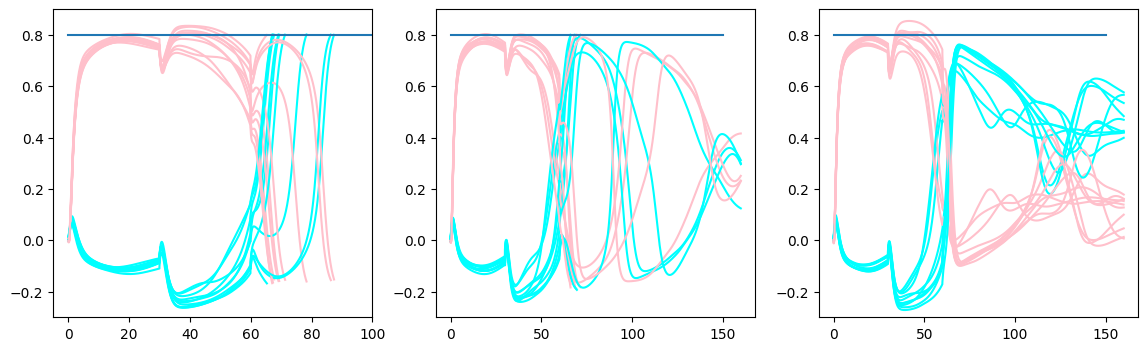

In [45]:
pl.figure(figsize=(14,4))
ifig=1
for i in range(len(list_pert_ids)):
    if i in [0,6,10]:
        dyn_dict=list_all_pert[i]
        NNtmp=dyn_dict["NNnew"]
        dyn_tmp,t_tmp,_=get_sepdata(dyn_dict,thrs_sep=0.8)
        tmptrgt=np.hstack((NNtmp.ipt_trgt[1][0][2][:NNtmp.Ntrgt,:],NNtmp.ipt_trgt[1][1][2][:NNtmp.Ntrgt,:]))

        pl.subplot(1,3,ifig)
        ifig+=1
        for i in range(10):
            tmpdyn=dyn_tmp[i][iset][1:,:NNtmp.Ntrgt]@tmptrgt/NNtmp.Ntrgt
            tmpt=t_tmp[i][iset][1:]-t_tmp[i][iset][1]
            pl.plot(tmpt,tmpdyn[:,0],c="cyan")
            pl.plot(tmpt,tmpdyn[:,1],c="pink")
        pl.plot([0,150],[0.8,0.8])
        pl.ylim(-0.3,0.9)
        if ifig==2:
            pl.xlim(-5,100)
pl.savefig("DMS_diff_wandering_dyn.eps")

## beta again (Fig 5)

In [ ]:
### generation of sample trials  in the normal condition
list_net=get_success_net_DMS()

imp.reload(nn)
purturb_inpt="_"

list_all_norm=[]
for inet in list_inet:
    NNnew=model_initialization_rcl(inet,nn.myNN("DMS",inet),BETA=BETA,gamma=1.2,_flg="DMS")  # copy instance parameters used in learning 

    NNnew.BETArcl1=NNnew.BETA
    NNnew.BETArcl2=NNnew.BETA
    NNnew.Nround=1
    NNnew.flg1=purturb_inpt
    _,_,dyn,dyn1,t_tic=NNnew.calc_dyn([_,_],True,False)

    list_all_norm.append({"dyn":copy.deepcopy(dyn),"dyn1":copy.deepcopy(dyn1),"t_tic":copy.deepcopy(t_tic),"NNnew":copy.deepcopy(NNnew)})

In [58]:
### generation of sample trials  in the diff beta including the original beta

imp.reload(nn)
list_inet=get_success_net_DMS()

is_just_before=True  # true: beta is changed just before 2nd stimuli (used in the paper)

BETA=1.5  # for the paper 2024.10.13
is_save=True
is_rsuc=False

if is_save:
    list_all_beta=[]
if is_rsuc: # calculation of success ratio and RT
    r_suc_all,mRT_all=[],[]

list_beta=[1.,1.1,1.25,1.5,1.75,2.,2.25,2.5] # beta=1.5 is used in the learning


purturb_inpt="_"  # purturbation on the input is or not.
n_trials=10

 

for idnet, inet in enumerate(list_inet):
    if is_save:
        list_all_beta.append([])

    if is_rsuc:
        r_suc,mRT=[],[]

    for beta in list_beta:
        NNnew=model_initialization_rcl(inet,nn.myNN("DMS",inet),BETA=BETA,gamma=1.2,_flg="DMS")
        NNnew.flg1=purturb_inpt  # dummy   # random pertub input (only lrn proc) is not used
        NNnew.Nround=n_trials
        
        if is_just_before:
            NNnew.BETArcl1, NNnew.BETArcl2=BETA,beta
        else:
            NNnew.BETArcl1, NNnew.BETArcl2=beta,beta
        tmptrgt=np.hstack((NNnew.ipt_trgt[1][0][2][:NNnew.Ntrgt,:],NNnew.ipt_trgt[1][1][2][:NNnew.Ntrgt,:])) 
        # ipt_trgt[1][0][2]: match pattern ipt_trgt[1][1][2]: non-match
        _,_,dyn,dyn1,t_tic=NNnew.calc_dyn([_,_],True,False)
        
        if is_save:
            list_all_beta[-1].append({"dyn":copy.deepcopy(dyn),"dyn1":copy.deepcopy(dyn1),"t_tic":copy.deepcopy(t_tic),"NNnew":copy.deepcopy(NNnew)})
        if is_rsuc:
            tmp={"dyn":copy.deepcopy(dyn),"dyn1":copy.deepcopy(dyn1),"t_tic":copy.deepcopy(t_tic),"NNnew":copy.deepcopy(NNnew)}
            rtmp,rttmp=calc_rsuc_RT(tmp,beta)
            r_suc.append(rtmp[:]);    mRT.append(rttmp[:]);

    if is_rsuc:
        r_suc_all.append(np.array(r_suc))
        mRT_all.append(np.array(mRT))
if is_save:
    if is_just_before:
        f=open("./used_data/DMS_just_before_beta_dyn","wb")  #  case:    NNnew.BETArcl1, NNnew.BETArcl2=BETA,beta 
    else:
        f=open("./used_data/DMS_beta_dyn","wb")  #  case:    NNnew.BETArcl1, NNnew.BETArcl2=beta,beta 
    pickle.dump([list_all_beta,list_beta],f)
    f.close()
if is_rsuc:        
    np.savez("used_data/DMS_beta_rsuc_RT",rsuc=r_suc_all,RT=mRT_all,list_beta=list_beta)              

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
0 0.8125
1 0.8625
3 0.8375
5 0.9
7 0.8375
8 0.8125
9 0.8125


In [47]:

### stability  and ratio_suc (rsuc), reaction time (mRT)
Nsamp=5
BETA=1.5
list_inet=get_success_net_DMS()
#"""
if is_just_before:
    f = open("./used_data/DMS_just_before_beta_dyn","rb")
else:
    f = open("./used_data/DMS_beta_dyn","rb")
tmp=pickle.load(f)
list_all_beta,list_beta=tmp[0],tmp[1]
f.close()
#"""
ib=list(list_beta).index(BETA)  # get id of beta used in the learning


stab_all,rsuc_all,mRT_all,sdRT_all=[],[],[],[]
for idnet,inet in enumerate(list_inet[:-1]):
    stab,rsuc,mRT,sdRT=[],[],[],[]
    list_all=list_all_beta[idnet]
    stab=calc_stab_DMS(list_all,ib,list_beta)

    for ip,p in enumerate(list_beta):
        tmp=list_all[ip]
        rtmp,rttmp,sdrttmp=calc_rsuc_RT(tmp,p)
        rsuc.append(rtmp); mRT.append(rttmp); sdRT.append(sdrttmp)

    stab_all.append(stab);rsuc_all.append(rsuc);mRT_all.append(mRT);sdRT_all.append(sdRT)
stab_all=np.array(stab_all);rsuc_all=np.array(rsuc_all);mRT_all=np.array(mRT_all);sdRT_all=np.array(sdRT_all)

0 0.8125
1 0.8625
3 0.8375
5 0.9
7 0.8375
8 0.8125
9 0.8125


/var/folders/y5/y0w8x6853cz9j26g_c7135gr0000gn/T/ipykernel_34781/3645195096.py:11: RuntimeWarning: Mean of empty slice
  m_rsuc=np.mean(r_suc[:,1:],axis=1);mmRT=np.nanmean(mRT[:,1:],axis=1);msdRT=np.nanmean(sdRT[:,1:],axis=1)
/var/folders/y5/y0w8x6853cz9j26g_c7135gr0000gn/T/ipykernel_34781/3645195096.py:11: RuntimeWarning: Mean of empty slice
  m_rsuc=np.mean(r_suc[:,1:],axis=1);mmRT=np.nanmean(mRT[:,1:],axis=1);msdRT=np.nanmean(sdRT[:,1:],axis=1)
/var/folders/y5/y0w8x6853cz9j26g_c7135gr0000gn/T/ipykernel_34781/3645195096.py:11: RuntimeWarning: Mean of empty slice
  m_rsuc=np.mean(r_suc[:,1:],axis=1);mmRT=np.nanmean(mRT[:,1:],axis=1);msdRT=np.nanmean(sdRT[:,1:],axis=1)


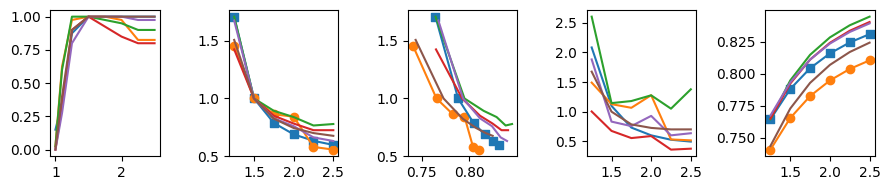

In [48]:
## plot the RT change, stability change.
t_onset=60
ib=list(list_beta).index(BETA)

mset=["s","o"]
fig=pl.figure(figsize=(9,2))
ax1,ax2,ax3,ax4,ax5=fig.add_subplot(151),fig.add_subplot(152),fig.add_subplot(153),fig.add_subplot(154),fig.add_subplot(155)

for idnet,inet in enumerate(list_inet[:6]):  # idnet=6 (inet=9) shows low performance, so we skip this.
    r_suc,mRT,sdRT=rsuc_all[idnet],mRT_all[idnet],sdRT_all[idnet]
    m_rsuc=np.mean(r_suc[:,1:],axis=1);mmRT=np.nanmean(mRT[:,1:],axis=1);msdRT=np.nanmean(sdRT[:,1:],axis=1)

    ax1.plot(r_suc[:,0],m_rsuc)
    idtmp=m_rsuc>0.75
    tmpRT=((mmRT-t_onset)/(mmRT[ib]-t_onset))[idtmp]
    ax2.plot(r_suc[:,0][idtmp],tmpRT)
    ax3.plot(np.mean(stab_all[idnet],axis=1)[idtmp],tmpRT)
    ax4.plot(r_suc[:,0][idtmp],msdRT[idtmp])
    ax5.plot(r_suc[:,0][idtmp],np.mean(stab_all[idnet],axis=1)[idtmp])
    
    if idnet in [0,1]:
        ax2.scatter(r_suc[:,0][idtmp],tmpRT,marker=mset[idnet])
        ax3.scatter(np.mean(stab_all[idnet],axis=1)[idtmp],tmpRT,marker=mset[idnet])
        ax5.scatter(r_suc[:,0][idtmp],np.mean(stab_all[idnet],axis=1)[idtmp],marker=mset[idnet])
pl.tight_layout()
#if is_just_before:
#    pl.savefig("DMS_justbefore_beta_stab.eps")

'\nif is_just_before:\n    pl.savefig("DMS_justbefore_beta_dyn_comp.eps")\nelse:\n    pl.savefig("DMS_beta_dyn_comp.eps")\n'

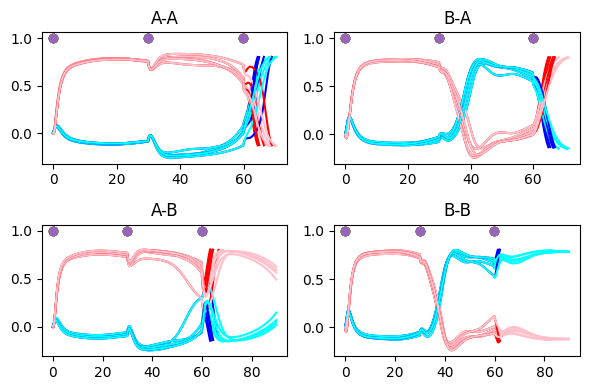

In [50]:
# plot dynamics for low and high beta
#"""
if is_just_before:
    f = open("./used_data/DMS_just_before_beta_dyn","rb")
else:
    f = open("./used_data/DMS_beta_dyn","rb")
tmp=pickle.load(f)
list_all_beta,list_beta=tmp[0],tmp[1]
f.close()
#"""

ib=list(list_beta).index(BETA)
#idnet,ib0=0,0  # ver 1 data
idnet,ib0=2,1


dict_data=list_all_beta[idnet][ib]
dict_data1=list_all_beta[idnet][ib0]
NNtmp=dict_data["NNnew"]
dyn_sep,t_sep,tid_sep=get_sepdata(dict_data,thrs_sep=0.8)
dyn_sep1,t_sep1,tid_sep1=get_sepdata(dict_data1,thrs_sep=0.8)
tmptrgt=np.hstack((NNtmp.ipt_trgt[1][0][2][:NNtmp.Ntrgt,:],NNtmp.ipt_trgt[1][1][2][:NNtmp.Ntrgt,:]))

list_title=["A-A","B-A","A-B","B-B"]

pl.figure(figsize=(6,4))
for itrial in range(4):
    pl.subplot(2,2,itrial+1)
    for iround in range(5):
        if iround==0:
            pl.title(list_title[itrial])
        tmpdyn=dyn_sep[iround][itrial][:,:NNtmp.Ntrgt]@tmptrgt[:,:]/NNtmp.Ntrgt
        tmpt=t_sep[iround][itrial]
        tmptid=tid_sep[iround][itrial]
        pl.plot(tmpt[1:]-tmpt[1],tmpdyn[1:,0],c="b")
        pl.plot(tmpt[1:]-tmpt[1],tmpdyn[1:,1],c="r")
        pl.scatter(tmpt[tmptid-tmptid[0]]-tmpt[1],np.ones(3))
        
        tmpdyn=dyn_sep1[iround][itrial][:,:NNtmp.Ntrgt]@tmptrgt[:,:]/NNtmp.Ntrgt
        tmpt=t_sep1[iround][itrial]
        tmptid=tid_sep1[iround][itrial]
        pl.plot(tmpt[1:]-tmpt[1],tmpdyn[1:,0],c="cyan")
        pl.plot(tmpt[1:]-tmpt[1],tmpdyn[1:,1],c="pink")
pl.tight_layout()

"""
if is_just_before:
    pl.savefig("DMS_justbefore_beta_dyn_comp.eps")
else:
    pl.savefig("DMS_beta_dyn_comp.eps")
"""

In [ ]:
# plot dynamics for low and high beta (expansion)

pl.figure()
#idnet,iset=0,1  # ver 1 data
idnet,iset=2,1

gen_conv_finalstate(list_all_beta[idnet][ib0],iset)
gen_conv_finalstate(list_all_beta[idnet][ib],iset)
#gen_conv_finalstate(list_all_beta[idnet][3],iset)
pl.xlim(147,160)

#pl.savefig("DMS_justbefore_beta_dyn_comp_expansion.eps")

# simple sequence generations

## generation of schematic image

In [ ]:
imp.reload(nn)
inet=0
NN=model_initialization_rcl(inet,nn.myNN("simple",inet),3,1,"simple",_Npat=5,_Nin=1)
NN.Nround=1
NN.Tdyn=1000
x0=NN.x_final
y0=NN.y_final

x,y,dyn_p,dyn1_p=NN.calc_dyn([x0,y0],True,False)

In [ ]:
pl.figure(figsize=(4,4))
pl.subplot(2,1,1)
pl.plot(dyn_p[:,0,0],dyn_p[:,1:,0]@NN.ipt_trgt[1]/NN.N)
pl.xlim(0,600)

pl.subplot(2,1,2)
pl.plot(dyn1_p[:,0,0],dyn1_p[:,1:,0]@NN.ipt_trgt[1]/NN.N)
pl.xlim(0,600)
pl.savefig("sample_dyn.eps")


In [ ]:
x=np.linspace(0,20,500)
s=0.8
a=[1,0.1,0.1,0.1,0.1]
l=[1,5,9,13,17]
pl.figure(figsize=(8,2))

for i in range(5):
    pl.subplot(1,5,i+1)
    y=0
    for j in range(5):
        y+=-a[(j-i)%5]*np.exp(-(x-l[j])**2/s**2)

    pl.plot(x,y)
    pl.tick_params(bottom=False, left=False, right=False, top=False,labelbottom=False, labelleft=False, labelright=False, labeltop=False)
    pl.ylim(-4,0.5)
pl.savefig("landscape.eps")

## learning  (data gemeration)

In [ ]:
###  simple sequence 
imp.reload(nn)
for inet in range(5,10):
    NN=nn.myNN("simple",inet,Nround=100,Nin=1,Npat=5,is_circle=True)
    NN.gamma  =1.0
    NN.gamma_y=0.5
    NN.BETA=3
    NN.THRS_STOP=0.9
    
    NN.map_schedule=[[0,i] for i in range(NN.Npat)]  
    
    x_fin,y_fin,dyn_lrn,dyn1_lrn=NN.calc_dyn(["_","_"],False,True)

## analysis for weak input  (Fig3)

In [4]:
#  calculation of periods dendent on context input strength
imp.reload(nn)
Nnet=10
net_list=np.arange(Nnet)

pert_in_all=[]
t_trans_all=[]
s_ipt=np.linspace(0.7,1.3,13)

for inet in range(Nnet):
    t_trans_all.append([])
    pert_in_all.append([])
    if not inet in net_list:
        continue

    NN=model_initialization_rcl(inet,nn.myNN("simple",inet),3,1,"simple",_Npat=5,_Nin=1)
    NN.Nround=1
    NN.Tdyn=4000
    x0=NN.x_final
    y0=NN.y_final

    for ifig,st in enumerate(s_ipt):
        NN.gamma=st
        x,y,dyn_p,dyn1_p=NN.calc_dyn([x0,y0],True,False)
        
        t_trans=get_trans(dyn_p)
        t_trans_all[-1].append(t_trans)

#tmp={"t_trans":t_trans_all,"Nnet":Nnet,"net_list":net_list,"s_ipt":s_ipt}
#f=open("./used_data/contI_t_trans","wb")        
#pickle.dump(tmp,f)
#f.close()

KeyboardInterrupt: 

In [5]:
def load_data_contI():
    s_ipt=np.linspace(0.7,1.3,13)
    f = open("./used_data/contI_t_trans","rb")
    tmp=pickle.load(f)
    t_trans_all,Nnet,net_list,s_ipt=tmp["t_trans"],tmp["Nnet"],tmp["net_list"],tmp["s_ipt"]
    f.close()
    #print(len(t_trans_all),len(t_trans_all[0]),s_ipt)
    T_peri_all,T_stay_all,T_trns_all=get_peri_stay_trns(t_trans_all,s_ipt,net_list)
    return s_ipt,T_peri_all,T_stay_all,T_trns_all

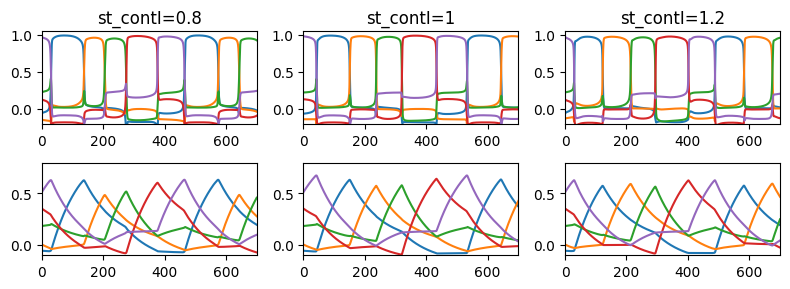

In [6]:
# plot dynamics

pl.figure(figsize=(8,3))
inet=0
for ifig, i in enumerate([2,6,10]):
    NN=model_initialization_rcl(inet,nn.myNN("simple",inet),3,1,"simple",_Npat=5,_Nin=1)
    NN.Nround=1
    NN.Tdyn=1000
    x0=NN.x_final
    y0=NN.y_final
    NN.gamma=s_ipt[i]
    x,y,dyn_p,dyn1_p=NN.calc_dyn([x0,y0],True,False)

        
    pl.subplot(2,3,ifig+1)
    pl.title("st_contI=%g"%s_ipt[i])
    pl.plot(dyn_p[:,0],dyn_p[:,1:,0]@NN.ipt_trgt[1]/NN.N)
    pl.xlim(0,700)
    pl.ylim(-0.2,1.05)
    
    pl.subplot(2,3,ifig+4)
    pl.plot(dyn1_p[:,0],dyn1_p[:,1:,0]@NN.ipt_trgt[1]/NN.N)
    pl.xlim(0,700)
    pl.ylim(-0.1,0.8)
pl.tight_layout()
#pl.savefig("contI_dyn_inet%d.eps"%inet)

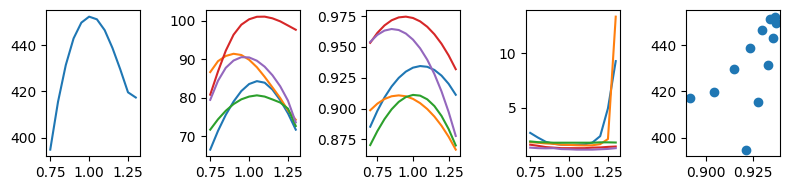

In [7]:
#  check property of the selected network
s_ipt,T_peri_all,T_stay_all,T_trns_all=load_data_contI()

inet=3
pl.figure(figsize=(8,2))
pl.subplot(1,5,1)
T=T_peri_all[inet]
pl.plot(s_ipt,T[:,0])

pl.subplot(1,5,2)
T=T_stay_all[inet]
pl.plot(s_ipt,T)

pl.subplot(1,5,3)
stab=comput_stab(inet,s_ipt,"contI")
pl.plot(s_ipt,stab[:,:])

pl.subplot(1,5,4)
T=T_trns_all[inet]
pl.plot(s_ipt,T)


pl.subplot(1,5,5)
pl.scatter(np.mean(stab,axis=1),T_peri_all[inet][:,0])
    
pl.tight_layout()
#pl.savefig("contI_T_inet%d.eps"%inet)

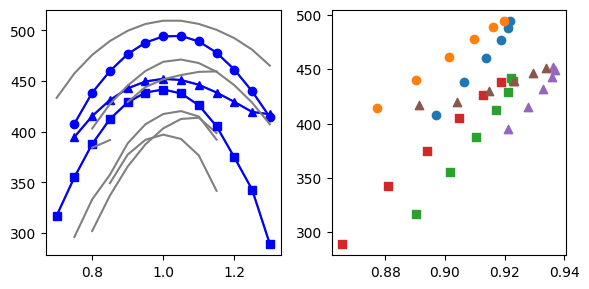

In [8]:
# plot period for all networks
marker_list=["o","x","s","^"]
pl.figure(figsize=(6,3))
pl.subplot(1,2,1)
for inet in range(Nnet):
    if inet in net_list:
        pl.plot(s_ipt,T_peri_all[inet][:,0],c="gray")
    if inet in [0,2,3]:
        pl.plot(s_ipt,T_peri_all[inet][:,0],c="b",marker=marker_list[inet])


pl.subplot(1,2,2)
for inet in range(Nnet):
    if inet in [0,2,3]:
        stab=comput_stab(inet,s_ipt,"contI")
        pl.scatter(np.mean(stab[:7],axis=1),T_peri_all[inet][:7,0],marker=marker_list[inet])
        pl.scatter(np.mean(stab[7:],axis=1),T_peri_all[inet][7:,0],marker=marker_list[inet])

pl.tight_layout()
#pl.savefig("contI_nets.eps")

##  dependence of beta (Fig.2)

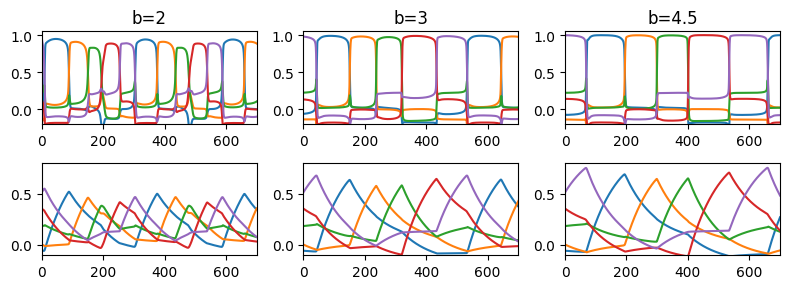

In [11]:
# plot sample dynamics

f = open("./used_data/beta_t_trans","rb")
tmp=pickle.load(f)
_,Nnet,net_list,beta_list = tmp["t_trans"],tmp["Nnet"],tmp["net_list"],tmp["beta_list"]
f.close()


pl.figure(figsize=(8,3))
inet=0
for ifig, i in enumerate([2,6,12]):
    NN=model_initialization_rcl(inet,nn.myNN("simple",inet),3,1,"simple",_Npat=5,_Nin=1)
    NN.Nround=1
    NN.Tdyn=1000
    x0=NN.x_final
    y0=NN.y_final
    NN.BETA=beta_list[i]
    x,y,dyn_p,dyn1_p=NN.calc_dyn([x0,y0],True,False)

        
    pl.subplot(2,3,ifig+1)
    pl.title("b=%g"%beta_list[i])
    pl.plot(dyn_p[:,0],dyn_p[:,1:,0]@NN.ipt_trgt[1]/NN.N)
    pl.xlim(0,700)
    pl.ylim(-0.2,1.05)
    
    pl.subplot(2,3,ifig+4)
    pl.plot(dyn1_p[:,0],dyn1_p[:,1:,0]@NN.ipt_trgt[1]/NN.N)
    pl.xlim(0,700)
    pl.ylim(-0.1,0.8)
pl.tight_layout()
#pl.savefig("beta_dyn_inet%d.eps"%inet)

In [15]:
# generation of time data about when the overlap crosses the threshold.
#Nnet=10
imp.reload(nn)
t_trans_all=[]

#beta_list=np.linspace(5,20,4)
net_list=np.arange(Nnet)

for inet in range(Nnet):
    t_trans_all.append([])
    if not inet in net_list:
        continue
            
    NN=model_initialization_rcl(inet,nn.myNN("simple",inet),3,1,"simple",_Npat=5,_Nin=1)
    NN.Nround=1
    NN.Tdyn=4000
    x0=NN.x_final
    y0=NN.y_final
    dyn_all,dyn1_all=[],[]
    for ifig,beta in enumerate(beta_list):
        NN.BETA=beta
        x,y,dyn_p,dyn1_p=NN.calc_dyn([x0,y0],True,False)
        dyn_all.append(dyn_p)
        dyn1_all.append(dyn1_p)
      
    for ifig,beta in enumerate(beta_list):
        NN.BETA=beta
        dyn_p,dyn1_p=dyn_all[ifig],dyn1_all[ifig]
          
        t_trans=get_trans(dyn_p)
        t_trans_all[-1].append(t_trans)
        
# save data
"""
tmp={"t_trans":t_trans_all,"Nnet":Nnet,"net_list":net_list,"beta_list":beta_list}
f=open("./used_data/high_beta_t_trans_1","wb")        
pickle.dump(tmp,f)
f.close()
"""

'\ntmp={"t_trans":t_trans_all,"Nnet":Nnet,"net_list":net_list,"beta_list":beta_list}\nf=open("./used_data/high_beta_t_trans","wb")        \npickle.dump(tmp,f)\nf.close()\n'

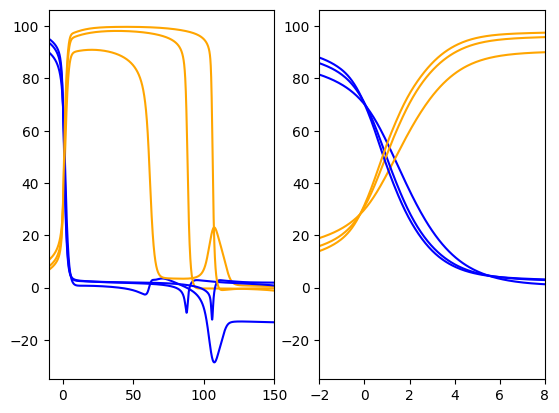

In [36]:
# plot examples illustrating stay and transient time
        
used_beta=[2,3,4.5]

imp.reload(nn)
t_trans_all=[]

Nnet=1
net_list=np.arange(Nnet)

for inet in range(Nnet):
    t_trans_all.append([])
    if not inet in net_list:
        continue
            
    NN=model_initialization_rcl(inet,nn.myNN("simple",inet),3,1,"simple",_Npat=5,_Nin=1)
    NN.Nround=1
    NN.Tdyn=4000
    x0=NN.x_final
    y0=NN.y_final
    dyn_all,dyn1_all=[],[]
    for ifig,beta in enumerate(used_beta):
        NN.BETA=beta
        x,y,dyn_p,dyn1_p=NN.calc_dyn([x0,y0],True,False)
        dyn_all.append(dyn_p)
        dyn1_all.append(dyn1_p)
      
    for ifig,beta in enumerate(used_beta):
        NN.BETA=beta
        dyn_p,dyn1_p=dyn_all[ifig],dyn1_all[ifig]
          
        t_trans=get_trans(dyn_p)
        t_trans_all[-1].append(t_trans)
       

inet=0

NN=model_initialization_rcl(inet,nn.myNN("simple",inet),3,1,"simple",_Npat=5,_Nin=1)

fig=pl.figure()

axes=[fig.add_subplot(1,2,1),fig.add_subplot(1,2,2)]

t_trans=t_trans_all[inet]
for ifig,beta in enumerate(used_beta):
    dyn_p,dyn1_p=dyn_all[ifig],dyn1_all[ifig]
    ttmp=t_trans[ifig][0][1][1]
    axes[0].plot(dyn_p[:,0]-ttmp,dyn_p[:,1:,0]@NN.ipt_trgt[1][:,:1],c="b")
    axes[0].plot(dyn_p[:,0]-ttmp,dyn_p[:,1:,0]@NN.ipt_trgt[1][:,1:2],c="orange")
    axes[0].set_xlim(-10,150)
    
    axes[1].plot(dyn_p[:,0]-ttmp,dyn_p[:,1:,0]@NN.ipt_trgt[1][:,:1],c="b")
    axes[1].plot(dyn_p[:,0]-ttmp,dyn_p[:,1:,0]@NN.ipt_trgt[1][:,1:2],c="orange")
    axes[1].set_xlim(-2,8)


    
#pl.savefig("ex_trns_stay.eps")

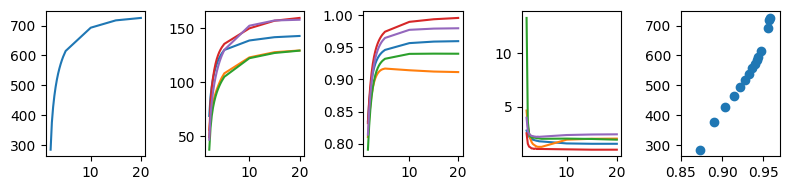

In [6]:
# check property of the selected network

inet=0

# date loaded
NN=model_initialization_rcl(inet,nn.myNN("simple",inet),3,1,"simple",_Npat=5,_Nin=1)
NN.Nround=1

f = open("./used_data/beta_t_trans","rb")
tmp=pickle.load(f)
t_trans_all,Nnet,net_list,beta_list = tmp["t_trans"],tmp["Nnet"],tmp["net_list"],tmp["beta_list"]
f.close()
T_peri_all,T_stay_all,T_trns_all=get_peri_stay_trns(t_trans_all,beta_list,net_list)

f = open("./used_data/high_beta_t_trans","rb")
tmp=pickle.load(f)
t_trans_all,Nnet,net_list,beta_list1 = tmp["t_trans"],tmp["Nnet"],tmp["net_list"],tmp["beta_list"]
f.close()
T_peri_all1,T_stay_all1,T_trns_all1=get_peri_stay_trns(t_trans_all,beta_list1,net_list)

T_peri_all,T_stay_all,T_trns_all=np.concatenate([T_peri_all,T_peri_all1],axis=1),np.concatenate([T_stay_all,T_stay_all1],axis=1),np.concatenate([T_trns_all,T_trns_all1],axis=1)
beta_list=np.concatenate([beta_list,beta_list1])
# load end


pl.figure(figsize=(8,2))
pl.subplot(1,5,1)
T=T_peri_all[inet]
#pl.plot(beta_list,T/T[5])
pl.plot(beta_list,T[:,0])

pl.subplot(1,5,2)
T=T_stay_all[inet]
pl.plot(beta_list,T)

pl.subplot(1,5,3)
stab=comput_stab(inet,beta_list,"beta")
pl.plot(beta_list,stab[:,:])

pl.subplot(1,5,4)
T=T_trns_all[inet]
pl.plot(beta_list,T)
#pl.yscale("log")

pl.subplot(1,5,5)
pl.scatter(np.mean(stab,axis=1),T_peri_all[inet][:,0])
pl.xlim(0.85,0.97)
    
pl.tight_layout()
#pl.savefig("beta_inet%d.eps"%inet)

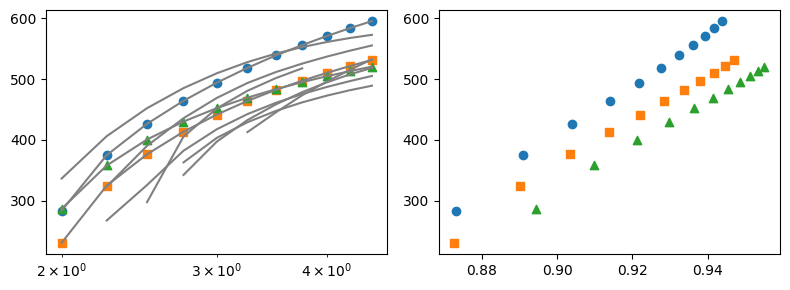

In [37]:
#plot period for all networks
inet=0
NN=model_initialization_rcl(inet,nn.myNN("simple",inet),3,1,"simple",_Npat=5,_Nin=1)  # for using parameters

#"""
f = open("./used_data/beta_t_trans","rb")
tmp=pickle.load(f)
t_trans_all,Nnet,net_list,beta_list = tmp["t_trans"],tmp["Nnet"],tmp["net_list"],tmp["beta_list"]
f.close()
T_peri_all,T_stay_all,T_trns_all=get_peri_stay_trns(t_trans_all,beta_list,net_list)

"""
f = open("./used_data/high_beta_t_trans","rb")
tmp=pickle.load(f)
t_trans_all,Nnet,net_list,beta_list1 = tmp["t_trans"],tmp["Nnet"],tmp["net_list"],tmp["beta_list"]
f.close()
T_peri_all1,T_stay_all1,T_trns_all1=get_peri_stay_trns(t_trans_all,beta_list1,net_list)

T_peri_all,T_stay_all,T_trns_all=np.concatenate([T_peri_all,T_peri_all1],axis=1),np.concatenate([T_stay_all,T_stay_all1],axis=1),np.concatenate([T_trns_all,T_trns_all1],axis=1)
beta_list=np.concatenate([beta_list,beta_list1])
"""

mset=["o","","s","^"]
pl.figure(figsize=(8,3))
pl.subplot(1,2,1)
for inet in range(Nnet):
    if inet in net_list:
        pl.plot(beta_list,T_peri_all[inet][:,0],c="gray")
    if inet in [0,2,3]:
        pl.scatter(beta_list,T_peri_all[inet][:,0],marker=mset[inet])
pl.xscale("log")
#"""
pl.subplot(1,2,2)
for inet in range(Nnet):
    if inet in [0,2,3]:
        stab=comput_stab(inet,beta_list,"beta")
        pl.scatter(np.mean(stab,axis=1),T_peri_all[inet][:,0],marker=mset[inet])
#"""
pl.tight_layout()
#pl.savefig("beta_stab.eps")